In [1]:
import pandas as pd
import numpy as np
import re
import joblib

from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize  
from nltk.stem import WordNetLemmatizer
import warnings

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# Plotting tools
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# borrowed from stackoverflow https://stackoverflow.com/a/49146722
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def remove_unwanted(document):

    # remove URLS 
    document = re.sub(r'http\S+', ' ', document)
    # remove emoji's
    document = remove_emoji(document)
    # remove punctuation
    document = re.sub("[^0-9A-Za-z ]", "" , document)
    # remove double spaces
    document = document.replace('  ',"")
    
    return document.strip()

In [3]:
# print(data[["Likes","Retweets"]].describe())
# extracted_data = data[(data["Likes"] >= 3) & (data["Retweets"] >= 2)]
# text_corpus = extracted_data["Tweet"]

In [4]:
data = pd.read_csv("/kaggle/input/harvey-stressor/Harvey_Tweets_with_emotion.csv")

exclusive_emotion = ["approval","desire","admiration","love","gratitude","excitement","optimism","joy","amusement","neutral"]
extracted_data = data.loc[~data["Emotion"].isin(exclusive_emotion)]
text_corpus = extracted_data["Tweet"]

In [5]:
new_corpus = []

for text in text_corpus:

    clean_text = remove_unwanted(str(text))
    clean_text = ' '.join( [w for w in clean_text.split() if len(w)>1] )
    new_corpus.append(clean_text)

new_corpus = np.array(new_corpus)

In [6]:
tokenizer = RegexpTokenizer(r'\w+')

tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize,
                        max_features=  500,
                        encoding='utf-8')

train_data = tfidf.fit_transform(new_corpus.astype('U'))


In [7]:
# Materialize the sparse data
data_dense = train_data.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.1021246271467693 %


## SAMPLE LDA

In [8]:
warnings.filterwarnings('ignore')
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations  
                                      random_state=100,          # Random state
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(train_data)

print(lda_model)  # Model attributes

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


LatentDirichletAllocation(n_components=20, n_jobs=-1, random_state=100)


In [9]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(train_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(train_data))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -1330892.9233752906
Perplexity:  684.2245645939216
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


## GridSearch LDA

In [10]:
# Define Search Param
search_params = {'n_components': [5,6,7,8,9,10], 'learning_decay': [.5,.6,.7,.8,.9]}
# search_params = {'n_components': [10, 15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(n_jobs=-1)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, verbose=3, cv=5)

# Do the Grid Search
model.fit(train_data)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END learning_decay=0.5, n_components=5;, score=-249433.770 total time= 1.1min
[CV 2/5] END learning_decay=0.5, n_components=5;, score=-248452.331 total time= 1.1min
[CV 3/5] END learning_decay=0.5, n_components=5;, score=-249518.125 total time= 1.1min
[CV 4/5] END learning_decay=0.5, n_components=5;, score=-253031.100 total time= 1.1min
[CV 5/5] END learning_decay=0.5, n_components=5;, score=-253376.829 total time= 1.1min
[CV 1/5] END learning_decay=0.5, n_components=6;, score=-252987.339 total time= 1.1min
[CV 2/5] END learning_decay=0.5, n_components=6;, score=-251151.451 total time= 1.0min
[CV 3/5] END learning_decay=0.5, n_components=6;, score=-253387.965 total time= 1.0min
[CV 4/5] END learning_decay=0.5, n_components=6;, score=-256038.908 total time= 1.0min
[CV 5/5] END learning_decay=0.5, n_components=6;, score=-255979.601 total time= 1.0min
[CV 1/5] END learning_decay=0.5, n_components=7;, score=-255586.152 

GridSearchCV(cv=5, estimator=LatentDirichletAllocation(n_jobs=-1),
             param_grid={'learning_decay': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'n_components': [5, 6, 7, 8, 9, 10]},
             verbose=3)

In [11]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(train_data))

Best Model's Params:  {'learning_decay': 0.6, 'n_components': 5}
Best Log Likelihood Score:  -249933.55966002084
Model Perplexity:  376.96488686037503


In [12]:
joblib.dump(model, 'grid_search_300.pkl')

['grid_search_300.pkl']

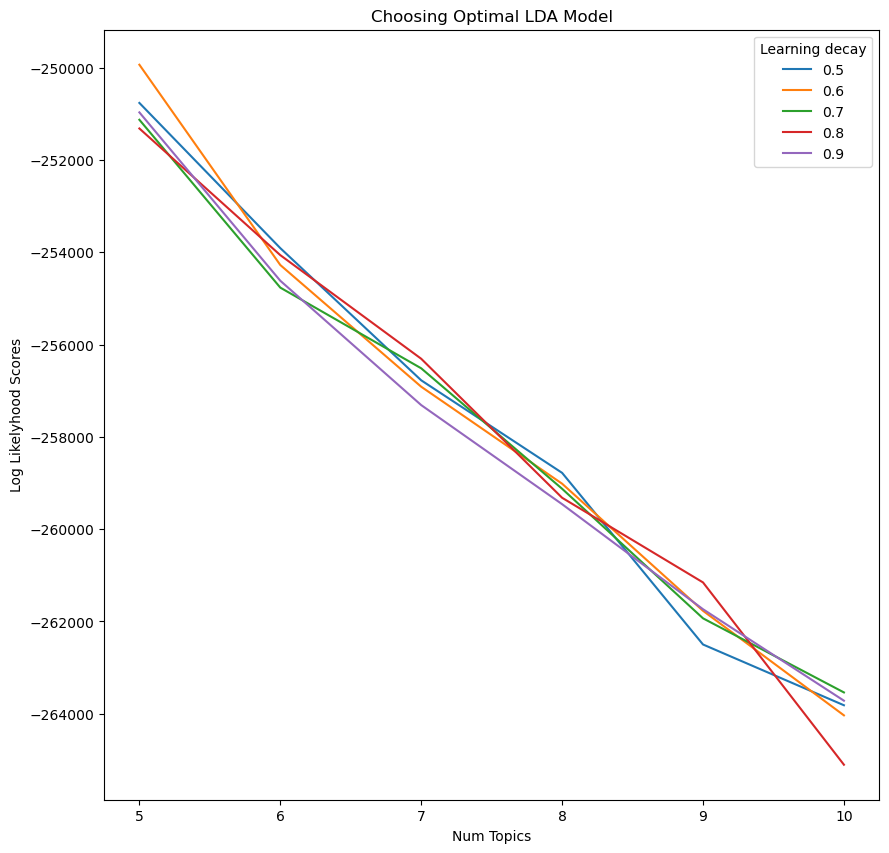

In [13]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5,6,7,8,9,10]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_6 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.6]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_8 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.8]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]


# Show graph
plt.figure(figsize=(10, 10))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_6, label='0.6')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_8, label='0.8')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.ticklabel_format(style='plain', useOffset=False, axis='y') 
plt.legend(title='Learning decay', loc='best')
plt.show()

In [14]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(train_data)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(extracted_data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(30).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.080000,0.450000,0.070000,0.080000,0.330000,1
Doc1,0.060000,0.060000,0.060000,0.600000,0.220000,3
Doc2,0.070000,0.410000,0.070000,0.380000,0.070000,1
Doc3,0.470000,0.070000,0.070000,0.070000,0.320000,0
Doc4,0.060000,0.770000,0.060000,0.060000,0.060000,1
Doc5,0.080000,0.080000,0.680000,0.080000,0.080000,2
Doc6,0.330000,0.080000,0.080000,0.080000,0.420000,4
Doc7,0.530000,0.060000,0.060000,0.300000,0.060000,0
Doc8,0.600000,0.100000,0.100000,0.100000,0.100000,0
Doc9,0.060000,0.610000,0.050000,0.230000,0.050000,1


In [15]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,29028
1,3,22579
2,2,17510
3,4,14722
4,1,14390


In [16]:
# Print the topics with their terms
terms = tfidf.get_feature_names_out()
lda_components = best_lda_model.components_

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['safe', 'hurricaneharvey', 'stay', 'prayers', 'path', 'hurricane', 'texas', 'harvey', 'praying', 'affected']
Topic 1:  ['hurricane', 'harvey', 'texas', 'hit', 'flooding', 'im', 'catastrophic', 'coast', 'hurricaneharvey', 'storm']
Topic 2:  ['hurricane', 'harvey', 'category', 'breaking', 'landfall', 'texas', 'storm', 'winds', 'fuck', 'hurricaneharvey']
Topic 3:  ['hurricane', 'harvey', 'hurricaneharvey', 'just', 'dont', 'did', 'like', 'im', 'bad', 'coming']
Topic 4:  ['hurricane', 'harvey', 'help', 'victims', 'disaster', 'texas', 'major', 'heres', 'trump', 'pray']


In [17]:
 cluster_no = best_lda_model.n_components

# Construct the k-means clusters
clusters = KMeans(n_clusters=cluster_no, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.64  0.33  0.39  0.46  0.34]
 [ 0.75 -0.16 -0.31 -0.52 -0.2 ]]
Perc of Variance Explained: 
 [0.02 0.34]


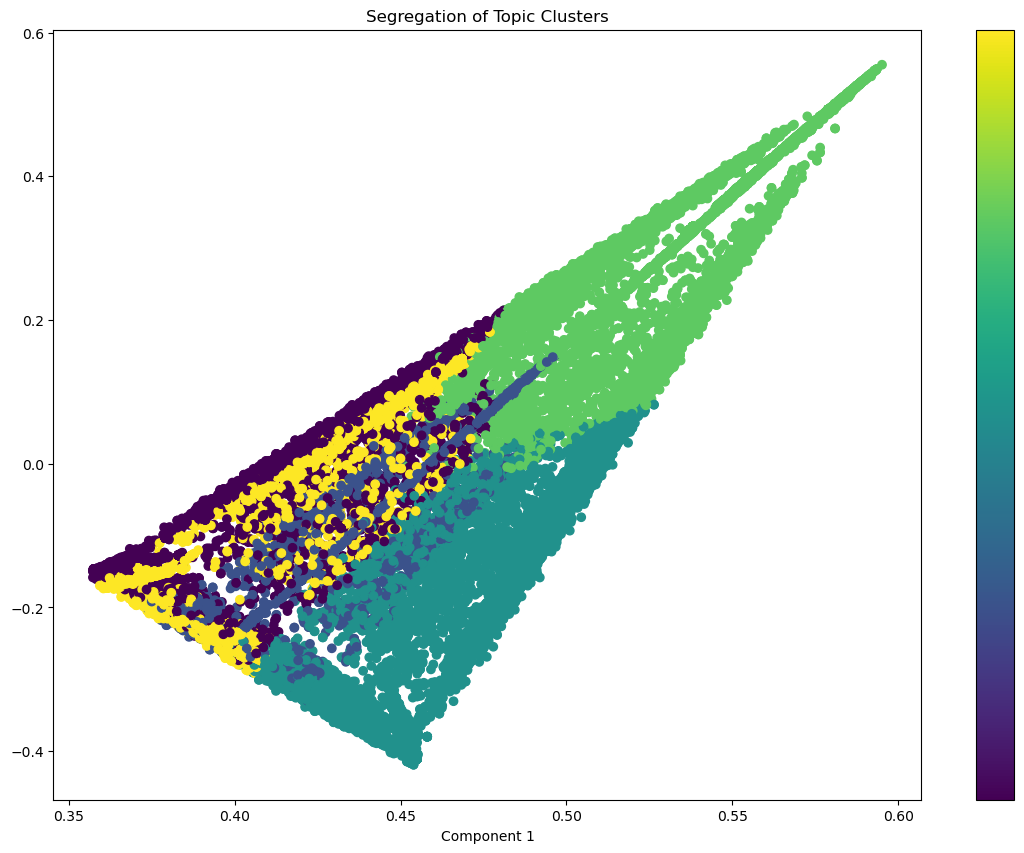

In [18]:
# Plot
plt.figure(figsize=(14, 10))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.colorbar(ticks=[])

## Auxiliary Testing

In [19]:
# # Define the number of topics or components
# num_components=10

# # Create LDA object
# model=LatentDirichletAllocation(n_components=num_components)

# # Fit and Transform SVD model on data
# lda_matrix = model.fit_transform(train_data)

# # Get Components 
# lda_components=model.components_

In [20]:
# Print the topics with their terms
# terms = tfidf.get_feature_names_out()

# for index, component in enumerate(lda_components):
#     zipped = zip(terms, component)
#     top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
#     top_terms_list=list(dict(top_terms_key).keys())
#     print("Topic "+str(index)+": ",top_terms_list)